In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader 

from snr.calc_snr import CalcSNR, SnrCalcStrategy

In [2]:
DATASETS_ORIGINS = ['stead', 'geofon', 'dummydataset', 'ethz', 'iquique']
dataset_origin = 'geofon'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:
SBD_CLASSES={'ethz':sbd.ETHZ, 'geofon':sbd.GEOFON}
SBD_CLASS=SBD_CLASSES[dataset_origin]
SBD_CLASS

seisbench.data.geofon.GEOFON

In [4]:
NUM_SAMPLES=3001
PHASE_LABEL = 'P' # 'S'
SAMPLING_RATE = 100
SNR_THRESHOLD = 20
BATCH_SIZE=1000

In [5]:
SAVE_TO_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_trainset_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'
TARGETS_PATH = f'/home/moshe/datasets/GFZ/targets/{dataset_origin}/'

In [6]:
assert os.path.exists(SAVE_TO_PATH), f'Path {SAVE_TO_PATH} does not exist'
assert os.path.exists(TARGETS_PATH), f'Path {TARGETS_PATH} does not exist'

## Download Data and Load to Memory

In [7]:
# Take only test data
data = SBD_CLASS(sampling_rate=SAMPLING_RATE, force=True).train()
print(data)

GEOFON - 161328 traces


In [8]:
# !mkdir targets
# !mkdir targets/ethz
# !mkdir targets/geofon
#
# #ethz
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task23.csv
# !mv *.csv targets/ethz
#
# #geofon
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task23.csv
# !mv *.csv targets/geofon

targets_task23 = pd.read_csv(os.path.join(TARGETS_PATH,'task23.csv'))

In [9]:
merged_metadata = pd.merge(data.metadata, targets_task23, on='trace_name')

In [10]:
requested_event_list=[]

In [11]:
filtered_metadata = merged_metadata[(merged_metadata.phase_label == PHASE_LABEL) ]
if requested_event_list:
  filtered_metadata = filtered_metadata[filtered_metadata.source_id.isin(requested_event_list)]
else:
  print('All events will contribute to the resulting dataset')

gen  = sbg.SteeredGenerator(data, filtered_metadata )
len(gen)

All events will contribute to the resulting dataset


166607

In [12]:
augmentations = [
            sbg.ChangeDtype(np.float32),
            sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
            sbg.SteeredWindow(windowlen=NUM_SAMPLES, strategy="pad")
        ]

gen.add_augmentations(augmentations)

@gen.augmentation
def get_arrival_sample(state_dict):
  _, metadata = state_dict["X"]
  key = f"trace_{state_dict['_control_']['full_phase_label']}_arrival_sample"
  state_dict['station_code'] = (metadata['station_code'], key)
  state_dict["onset_sample"] = (metadata[key], None)

num_dataset_traces = int(len(gen))

f'There are {num_dataset_traces} traces in the resulting dataset.'

'There are 166607 traces in the resulting dataset.'

In [13]:
loader = DataLoader(gen, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
len(loader)

167

In [14]:
def load_batch():
    print(f'Load {BATCH_SIZE} traces')
    dataset_dict = next(iter(loader))
    dataset=dataset_dict['X']
    print(f'{dataset.shape[0]} traces loaded.')
    print(f'Each trace has {dataset.shape[1]} channels.')
    print(f'Each channel has {dataset.shape[-1]} samples.')
    labels = dataset_dict['onset_sample']
    print(f'{labels.shape[0]} labels loaded. Each trace has a corresponding label')
    return dataset, labels

In [15]:
def calc_batch_snr(batch_traces, labels):
    batch_size = batch_traces.shape[0]
    assert batch_size == BATCH_SIZE
    assert batch_size == labels.shape[0]

    calc_snr = CalcSNR(SnrCalcStrategy.ENERGY_RATIO)
    # take the 0 channel for SNR calculations
    SNR_energy_ratio = torch.tensor([calc_snr(trace=batch_traces[i,0,:].numpy(), onset=int(labels[i]))
                             for i in range(batch_size)])

    print('SNR_energy_ratio shape', SNR_energy_ratio.shape)

    return SNR_energy_ratio

# fig, ax = plt.subplots(figsize=(15, 10))
# ax.scatter(range(num_dataset_traces), SNR_energy_ratio);

In [23]:
traces, labels = load_batch()
print(traces.shape, labels.shape)
SNR = calc_batch_snr(batch_traces=traces, labels=labels)

Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
torch.Size([1000, 3, 3001]) torch.Size([1000])
SNR_energy_ratio shape torch.Size([1000])


In [33]:
torch.argwhere((5 < SNR)  & (SNR < 7)).squeeze().shape

torch.Size([89])

tensor([ 1.,  0.,  0.,  0.,  0.,  2.,  4.,  5.,  2.,  7.,  4.,  6.,  9.,  8.,
        20., 21., 40., 17., 32., 39., 34., 37., 37., 35., 33., 37., 27., 32.,
        22., 24., 24., 20., 16., 13., 18., 16., 10., 16., 19., 13., 14., 13.,
         7., 11., 16., 12., 14.,  8.,  7.,  9.,  5.,  5., 14., 15.,  5.,  5.,
         8.,  6.,  5.,  8.,  9.,  2.,  6.,  6.,  9.,  5.,  3.,  9.,  3.,  6.,
         5.,  4.,  3.,  7.,  2.,  4.,  2.,  1.,  4.,  2.,  0.,  0.,  2.,  1.,
         1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
         2.,  1.]) 
 tensor([-11.2239, -10.6154, -10.0069,  -9.3984,  -8.7899,  -8.1814,  -7.5729,
         -6.9643,  -6.3558,  -5.7473,  -5.1388,  -4.5303,  -3.9218,  -3.3133,
         -2.7048,  -2.0963,  -1.4878,  -0.8793,  -0.2708,   0.3378,   0.9463,
          1.5548,   2.1633,   2.7718,   3.3803,   3.9888,   4.5973,   5.2058,
          5.8143,   6.4228,   7.0314,   7.6399,   8.2484,   8.8569,   9.4654,
         10.0739,  10.6824,  11.2909,  11.8

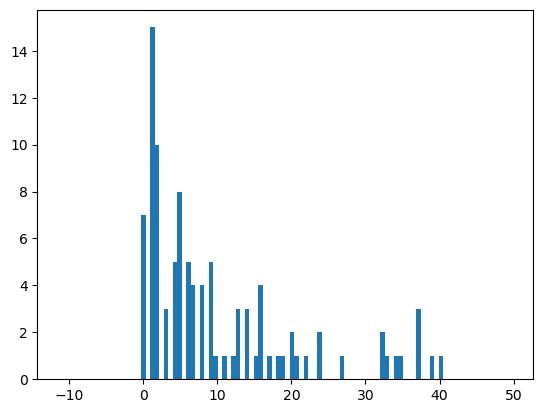

In [18]:
hist, edges = SNR.histogram(bins=100)
print(hist, '\n', edges)
plt.hist(hist, edges);

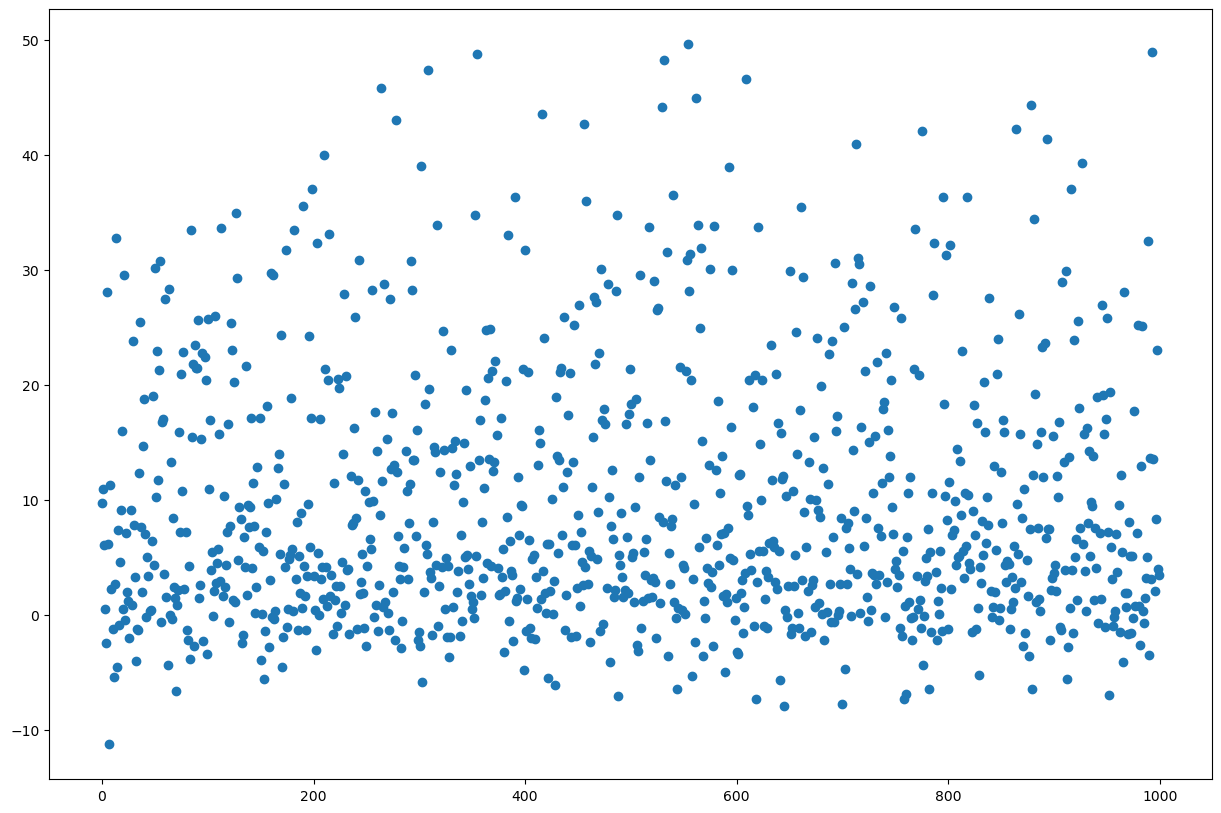

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(range(SNR.shape[0]), SNR);

In [20]:
def get_traces_in_snr_bounds(traces: torch.tensor, labels: torch.tensor, SNR: torch.tensor, low: float, high: float):
    traces_in_snr_bounds_indices = torch.argwhere((SNR>low) & (SNR<high)).squeeze()
    snr_of_traces_in_snr_bounds = SNR[traces_in_snr_bounds_indices]
    traces_in_snr_bounds = traces[traces_in_snr_bounds_indices]
    labels_of_traces_in_snr_bounds = labels[traces_in_snr_bounds_indices]

    print(f'There are {traces.shape[0]} traces in the dataset')
    print(f'There are {len(traces_in_snr_bounds_indices)} traces with  {low} < SNRs < {high} dB')
    print(f'traces_in_snr_bounds shape {traces_in_snr_bounds.shape}')

    return traces_in_snr_bounds, labels_of_traces_in_snr_bounds, snr_of_traces_in_snr_bounds

In [22]:
bounds = [-20, 0, 2, 5, 10, 20, 100]
batch_tuple_traces_labels_snrs_in_bounds_list = [get_traces_in_snr_bounds(traces=traces, labels=labels, SNR=SNR, low=bounds[i], high=bounds[i + 1]) for i in range(len(bounds) - 1)]
# [t.shape for t in batch_tuple_traces_labels_snrs_in_bounds_list]

There are 1000 traces in the dataset
There are 162 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([162, 3, 3001])
There are 1000 traces in the dataset
There are 114 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([114, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 181 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([181, 3, 3001])
There are 1000 traces in the dataset
There are 193 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([193, 3, 3001])
There are 1000 traces in the dataset
There are 183 traces with  20 < SNRs < 100 dB
traces_in_snr_bounds shape torch.Size([183, 3, 3001])


In [24]:
for i in tqdm(range(len(loader))):
    traces, labels = load_batch()
    SNR = calc_batch_snr(batch_traces=traces, labels=labels)
    bounds = [-20, 0, 2, 5, 10, 20, 100]
    batch_tuple_traces_labels_snrs_in_bounds_list = [get_traces_in_snr_bounds(traces=traces, labels=labels, SNR=SNR, low=bounds[i], high=bounds[i + 1]) for i in range(len(bounds) - 1)]

    for j, (t,l,s) in enumerate(batch_tuple_traces_labels_snrs_in_bounds_list):
        suffix = f'_{dataset_origin}_bounds_{bounds[j]}_{bounds[j+1]}.pt'
        if i > 0:
            t_prev = torch.load(os.path.join(SAVE_TO_PATH, 'traces' + suffix))
            l_prev = torch.load(os.path.join(SAVE_TO_PATH, 'labels' + suffix))
            s_prev = torch.load(os.path.join(SAVE_TO_PATH, 'snr' + suffix))

            t = torch.vstack((t_prev, t))
            l = torch.vstack((l_prev.unsqueeze(dim=1), l.unsqueeze(dim=1))).squeeze()
            s = torch.vstack((s_prev.unsqueeze(dim=1), s.unsqueeze(dim=1))).squeeze()

        torch.save(t, os.path.join(SAVE_TO_PATH, 'traces' + suffix))
        torch.save(l, os.path.join(SAVE_TO_PATH, 'labels' + suffix))
        torch.save(s, os.path.join(SAVE_TO_PATH, 'snr' + suffix))

    print(t.shape, l.shape, s.shape)


    # (full_high_SNR_traces, full_high_SNR_traces_labels, full_SNR_of_high_SNR_traces) = (batch_traces_in_bounds_list.clone(), batch_labels_in_snr_bounds_list.clone(), batch_SNR_of_high_SNR_traces.clone()) if i == 0 else \
    #     (torch.vstack((full_high_SNR_traces, batch_traces_in_bounds_list)), torch.vstack((full_high_SNR_traces_labels.unsqueeze(dim=1), batch_labels_in_snr_bounds_list.unsqueeze(dim=1))).squeeze(), torch.vstack((full_SNR_of_high_SNR_traces.unsqueeze(dim=1), batch_SNR_of_high_SNR_traces.unsqueeze(dim=1))).squeeze())

# full_SNR_of_high_SNR_traces.shape, full_high_SNR_traces.shape, full_high_SNR_traces_labels.shape

  0%|          | 0/167 [00:00<?, ?it/s]

Load 1000 traces


  1%|          | 1/167 [00:07<21:23,  7.73s/it]

1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 170 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([170, 3, 3001])
There are 1000 traces in the dataset
There are 115 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([115, 3, 3001])
There are 1000 traces in the dataset
There are 156 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([156, 3, 3001])
There are 1000 traces in the dataset
There are 187 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([187, 3, 3001])
There are 1000 traces in the dataset
There are 210 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([210, 3, 3001])
There are 1000 traces in the dataset
There are 162 traces with  20 < SNRs < 100 dB
traces_in_snr_bounds shape torch.Size([162, 3, 3001])
torch.Size(

  1%|          | 2/167 [00:14<20:23,  7.42s/it]

torch.Size([317, 3, 3001]) torch.Size([317]) torch.Size([317])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 176 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([176, 3, 3001])
There are 1000 traces in the dataset
There are 129 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([129, 3, 3001])
There are 1000 traces in the dataset
There are 153 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([153, 3, 3001])
There are 1000 traces in the dataset
There are 166 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([166, 3, 3001])
There are 1000 traces in the dataset
There are 216 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([216, 3, 3001])
There are 1000 traces in the dataset
There are 160 traces with  20 <

  2%|▏         | 3/167 [00:21<19:45,  7.23s/it]

torch.Size([477, 3, 3001]) torch.Size([477]) torch.Size([477])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 189 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([189, 3, 3001])
There are 1000 traces in the dataset
There are 111 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([111, 3, 3001])
There are 1000 traces in the dataset
There are 175 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([175, 3, 3001])
There are 1000 traces in the dataset
There are 172 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([172, 3, 3001])
There are 1000 traces in the dataset
There are 182 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([182, 3, 3001])
There are 1000 traces in the dataset
There are 171 traces with  20 <

  2%|▏         | 4/167 [00:29<19:30,  7.18s/it]

torch.Size([648, 3, 3001]) torch.Size([648]) torch.Size([648])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 171 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([171, 3, 3001])
There are 1000 traces in the dataset
There are 128 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([128, 3, 3001])
There are 1000 traces in the dataset
There are 162 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([162, 3, 3001])
There are 1000 traces in the dataset
There are 177 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([177, 3, 3001])
There are 1000 traces in the dataset
There are 216 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([216, 3, 3001])
There are 1000 traces in the dataset
There are 146 traces with  20 <

  3%|▎         | 5/167 [00:36<19:13,  7.12s/it]

torch.Size([794, 3, 3001]) torch.Size([794]) torch.Size([794])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 182 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([182, 3, 3001])
There are 1000 traces in the dataset
There are 132 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([132, 3, 3001])
There are 1000 traces in the dataset
There are 153 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([153, 3, 3001])
There are 1000 traces in the dataset
There are 161 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([161, 3, 3001])
There are 1000 traces in the dataset
There are 196 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([196, 3, 3001])
There are 1000 traces in the dataset
There are 176 traces with  20 <

  4%|▎         | 6/167 [00:43<19:02,  7.09s/it]

torch.Size([970, 3, 3001]) torch.Size([970]) torch.Size([970])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 179 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([179, 3, 3001])
There are 1000 traces in the dataset
There are 124 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([124, 3, 3001])
There are 1000 traces in the dataset
There are 146 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([146, 3, 3001])
There are 1000 traces in the dataset
There are 191 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([191, 3, 3001])
There are 1000 traces in the dataset
There are 198 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([198, 3, 3001])
There are 1000 traces in the dataset
There are 162 traces with  20 <

  4%|▍         | 7/167 [00:50<18:51,  7.07s/it]

torch.Size([1132, 3, 3001]) torch.Size([1132]) torch.Size([1132])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 165 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([165, 3, 3001])
There are 1000 traces in the dataset
There are 115 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([115, 3, 3001])
There are 1000 traces in the dataset
There are 175 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([175, 3, 3001])
There are 1000 traces in the dataset
There are 191 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([191, 3, 3001])
There are 1000 traces in the dataset
There are 186 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([186, 3, 3001])
There are 1000 traces in the dataset
There are 168 traces with  2

  5%|▍         | 8/167 [00:57<19:02,  7.19s/it]

torch.Size([1300, 3, 3001]) torch.Size([1300]) torch.Size([1300])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 191 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([191, 3, 3001])
There are 1000 traces in the dataset
There are 118 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([118, 3, 3001])
There are 1000 traces in the dataset
There are 149 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([149, 3, 3001])
There are 1000 traces in the dataset
There are 162 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([162, 3, 3001])
There are 1000 traces in the dataset
There are 209 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([209, 3, 3001])
There are 1000 traces in the dataset
There are 171 traces with  2

  5%|▌         | 9/167 [01:05<19:11,  7.29s/it]

torch.Size([1471, 3, 3001]) torch.Size([1471]) torch.Size([1471])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 167 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 140 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([140, 3, 3001])
There are 1000 traces in the dataset
There are 171 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([171, 3, 3001])
There are 1000 traces in the dataset
There are 160 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([160, 3, 3001])
There are 1000 traces in the dataset
There are 198 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([198, 3, 3001])
There are 1000 traces in the dataset
There are 164 traces with  2

  6%|▌         | 10/167 [01:12<19:22,  7.40s/it]

torch.Size([1635, 3, 3001]) torch.Size([1635]) torch.Size([1635])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 203 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([203, 3, 3001])
There are 1000 traces in the dataset
There are 120 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([120, 3, 3001])
There are 1000 traces in the dataset
There are 143 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([143, 3, 3001])
There are 1000 traces in the dataset
There are 178 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([178, 3, 3001])
There are 1000 traces in the dataset
There are 190 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([190, 3, 3001])
There are 1000 traces in the dataset
There are 166 traces with  2

  7%|▋         | 11/167 [01:20<19:23,  7.46s/it]

torch.Size([1801, 3, 3001]) torch.Size([1801]) torch.Size([1801])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 161 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([161, 3, 3001])
There are 1000 traces in the dataset
There are 117 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([117, 3, 3001])
There are 1000 traces in the dataset
There are 169 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([169, 3, 3001])
There are 1000 traces in the dataset
There are 179 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([179, 3, 3001])
There are 1000 traces in the dataset
There are 211 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([211, 3, 3001])
There are 1000 traces in the dataset
There are 163 traces with  2

  7%|▋         | 12/167 [01:27<19:10,  7.42s/it]

torch.Size([1964, 3, 3001]) torch.Size([1964]) torch.Size([1964])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 151 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([151, 3, 3001])
There are 1000 traces in the dataset
There are 130 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([130, 3, 3001])
There are 1000 traces in the dataset
There are 161 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([161, 3, 3001])
There are 1000 traces in the dataset
There are 179 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([179, 3, 3001])
There are 1000 traces in the dataset
There are 202 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([202, 3, 3001])
There are 1000 traces in the dataset
There are 177 traces with  2

  8%|▊         | 13/167 [01:35<19:24,  7.56s/it]

torch.Size([2141, 3, 3001]) torch.Size([2141]) torch.Size([2141])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 159 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([159, 3, 3001])
There are 1000 traces in the dataset
There are 116 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([116, 3, 3001])
There are 1000 traces in the dataset
There are 169 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([169, 3, 3001])
There are 1000 traces in the dataset
There are 185 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([185, 3, 3001])
There are 1000 traces in the dataset
There are 201 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([201, 3, 3001])
There are 1000 traces in the dataset
There are 170 traces with  2

  8%|▊         | 14/167 [01:43<19:23,  7.60s/it]

torch.Size([2311, 3, 3001]) torch.Size([2311]) torch.Size([2311])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 174 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([174, 3, 3001])
There are 1000 traces in the dataset
There are 128 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([128, 3, 3001])
There are 1000 traces in the dataset
There are 150 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([150, 3, 3001])
There are 1000 traces in the dataset
There are 188 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([188, 3, 3001])
There are 1000 traces in the dataset
There are 207 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([207, 3, 3001])
There are 1000 traces in the dataset
There are 152 traces with  2

  9%|▉         | 15/167 [01:51<19:57,  7.88s/it]

torch.Size([2463, 3, 3001]) torch.Size([2463]) torch.Size([2463])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 174 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([174, 3, 3001])
There are 1000 traces in the dataset
There are 126 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([126, 3, 3001])
There are 1000 traces in the dataset
There are 183 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([183, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 191 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([191, 3, 3001])
There are 1000 traces in the dataset
There are 159 traces with  2

 10%|▉         | 16/167 [02:00<20:24,  8.11s/it]

torch.Size([2622, 3, 3001]) torch.Size([2622]) torch.Size([2622])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 168 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([168, 3, 3001])
There are 1000 traces in the dataset
There are 137 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([137, 3, 3001])
There are 1000 traces in the dataset
There are 160 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([160, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 217 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([217, 3, 3001])
There are 1000 traces in the dataset
There are 151 traces with  2

 10%|█         | 17/167 [02:08<20:33,  8.22s/it]

torch.Size([2773, 3, 3001]) torch.Size([2773]) torch.Size([2773])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 178 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([178, 3, 3001])
There are 1000 traces in the dataset
There are 111 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([111, 3, 3001])
There are 1000 traces in the dataset
There are 183 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([183, 3, 3001])
There are 1000 traces in the dataset
There are 186 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([186, 3, 3001])
There are 1000 traces in the dataset
There are 187 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([187, 3, 3001])
There are 1000 traces in the dataset
There are 155 traces with  2

 11%|█         | 18/167 [02:17<20:59,  8.46s/it]

torch.Size([2928, 3, 3001]) torch.Size([2928]) torch.Size([2928])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 181 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([181, 3, 3001])
There are 1000 traces in the dataset
There are 110 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([110, 3, 3001])
There are 1000 traces in the dataset
There are 175 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([175, 3, 3001])
There are 1000 traces in the dataset
There are 168 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([168, 3, 3001])
There are 1000 traces in the dataset
There are 213 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([213, 3, 3001])
There are 1000 traces in the dataset
There are 153 traces with  2

 11%|█▏        | 19/167 [02:26<20:48,  8.43s/it]

torch.Size([3081, 3, 3001]) torch.Size([3081]) torch.Size([3081])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 174 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([174, 3, 3001])
There are 1000 traces in the dataset
There are 127 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([127, 3, 3001])
There are 1000 traces in the dataset
There are 150 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([150, 3, 3001])
There are 1000 traces in the dataset
There are 178 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([178, 3, 3001])
There are 1000 traces in the dataset
There are 212 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([212, 3, 3001])
There are 1000 traces in the dataset
There are 159 traces with  2

 12%|█▏        | 20/167 [02:34<20:44,  8.47s/it]

torch.Size([3240, 3, 3001]) torch.Size([3240]) torch.Size([3240])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 160 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([160, 3, 3001])
There are 1000 traces in the dataset
There are 136 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([136, 3, 3001])
There are 1000 traces in the dataset
There are 187 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([187, 3, 3001])
There are 1000 traces in the dataset
There are 182 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([182, 3, 3001])
There are 1000 traces in the dataset
There are 193 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([193, 3, 3001])
There are 1000 traces in the dataset
There are 142 traces with  2

 13%|█▎        | 21/167 [02:43<20:29,  8.42s/it]

torch.Size([3382, 3, 3001]) torch.Size([3382]) torch.Size([3382])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 156 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([156, 3, 3001])
There are 1000 traces in the dataset
There are 126 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([126, 3, 3001])
There are 1000 traces in the dataset
There are 182 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([182, 3, 3001])
There are 1000 traces in the dataset
There are 166 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([166, 3, 3001])
There are 1000 traces in the dataset
There are 204 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([204, 3, 3001])
There are 1000 traces in the dataset
There are 166 traces with  2

 13%|█▎        | 22/167 [02:51<20:22,  8.43s/it]

torch.Size([3548, 3, 3001]) torch.Size([3548]) torch.Size([3548])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 199 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([199, 3, 3001])
There are 1000 traces in the dataset
There are 112 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([112, 3, 3001])
There are 1000 traces in the dataset
There are 191 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([191, 3, 3001])
There are 1000 traces in the dataset
There are 180 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([180, 3, 3001])
There are 1000 traces in the dataset
There are 179 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([179, 3, 3001])
There are 1000 traces in the dataset
There are 139 traces with  2

 14%|█▍        | 23/167 [03:00<20:32,  8.56s/it]

torch.Size([3687, 3, 3001]) torch.Size([3687]) torch.Size([3687])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 166 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([166, 3, 3001])
There are 1000 traces in the dataset
There are 142 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([142, 3, 3001])
There are 1000 traces in the dataset
There are 163 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([163, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 206 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([206, 3, 3001])
There are 1000 traces in the dataset
There are 156 traces with  2

 14%|█▍        | 24/167 [03:09<20:40,  8.67s/it]

torch.Size([3843, 3, 3001]) torch.Size([3843]) torch.Size([3843])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 182 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([182, 3, 3001])
There are 1000 traces in the dataset
There are 124 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([124, 3, 3001])
There are 1000 traces in the dataset
There are 169 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([169, 3, 3001])
There are 1000 traces in the dataset
There are 169 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([169, 3, 3001])
There are 1000 traces in the dataset
There are 194 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([194, 3, 3001])
There are 1000 traces in the dataset
There are 162 traces with  2

 15%|█▍        | 25/167 [03:19<21:33,  9.11s/it]

torch.Size([4005, 3, 3001]) torch.Size([4005]) torch.Size([4005])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 160 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([160, 3, 3001])
There are 1000 traces in the dataset
There are 116 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([116, 3, 3001])
There are 1000 traces in the dataset
There are 163 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([163, 3, 3001])
There are 1000 traces in the dataset
There are 174 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([174, 3, 3001])
There are 1000 traces in the dataset
There are 208 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([208, 3, 3001])
There are 1000 traces in the dataset
There are 179 traces with  2

 16%|█▌        | 26/167 [03:31<23:12,  9.88s/it]

torch.Size([4184, 3, 3001]) torch.Size([4184]) torch.Size([4184])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 176 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([176, 3, 3001])
There are 1000 traces in the dataset
There are 120 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([120, 3, 3001])
There are 1000 traces in the dataset
There are 171 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([171, 3, 3001])
There are 1000 traces in the dataset
There are 165 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([165, 3, 3001])
There are 1000 traces in the dataset
There are 212 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([212, 3, 3001])
There are 1000 traces in the dataset
There are 156 traces with  2

 16%|█▌        | 27/167 [03:42<24:12, 10.38s/it]

torch.Size([4340, 3, 3001]) torch.Size([4340]) torch.Size([4340])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 167 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 119 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([119, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 185 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([185, 3, 3001])
There are 1000 traces in the dataset
There are 206 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([206, 3, 3001])
There are 1000 traces in the dataset
There are 156 traces with  2

 17%|█▋        | 28/167 [03:53<24:36, 10.62s/it]

torch.Size([4496, 3, 3001]) torch.Size([4496]) torch.Size([4496])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 180 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([180, 3, 3001])
There are 1000 traces in the dataset
There are 121 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([121, 3, 3001])
There are 1000 traces in the dataset
There are 161 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([161, 3, 3001])
There are 1000 traces in the dataset
There are 163 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([163, 3, 3001])
There are 1000 traces in the dataset
There are 209 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([209, 3, 3001])
There are 1000 traces in the dataset
There are 166 traces with  2

 17%|█▋        | 29/167 [04:05<25:09, 10.93s/it]

torch.Size([4662, 3, 3001]) torch.Size([4662]) torch.Size([4662])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 151 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([151, 3, 3001])
There are 1000 traces in the dataset
There are 120 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([120, 3, 3001])
There are 1000 traces in the dataset
There are 159 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([159, 3, 3001])
There are 1000 traces in the dataset
There are 202 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([202, 3, 3001])
There are 1000 traces in the dataset
There are 217 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([217, 3, 3001])
There are 1000 traces in the dataset
There are 151 traces with  2

 18%|█▊        | 30/167 [04:17<25:27, 11.15s/it]

torch.Size([4813, 3, 3001]) torch.Size([4813]) torch.Size([4813])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 175 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([175, 3, 3001])
There are 1000 traces in the dataset
There are 139 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([139, 3, 3001])
There are 1000 traces in the dataset
There are 167 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([167, 3, 3001])
There are 1000 traces in the dataset
There are 164 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([164, 3, 3001])
There are 1000 traces in the dataset
There are 198 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([198, 3, 3001])
There are 1000 traces in the dataset
There are 157 traces with  2

 19%|█▊        | 31/167 [04:29<26:00, 11.47s/it]

torch.Size([4970, 3, 3001]) torch.Size([4970]) torch.Size([4970])
Load 1000 traces
1000 traces loaded.
Each trace has 3 channels.
Each channel has 3001 samples.
1000 labels loaded. Each trace has a corresponding label
SNR_energy_ratio shape torch.Size([1000])
There are 1000 traces in the dataset
There are 162 traces with  -20 < SNRs < 0 dB
traces_in_snr_bounds shape torch.Size([162, 3, 3001])
There are 1000 traces in the dataset
There are 134 traces with  0 < SNRs < 2 dB
traces_in_snr_bounds shape torch.Size([134, 3, 3001])
There are 1000 traces in the dataset
There are 170 traces with  2 < SNRs < 5 dB
traces_in_snr_bounds shape torch.Size([170, 3, 3001])
There are 1000 traces in the dataset
There are 203 traces with  5 < SNRs < 10 dB
traces_in_snr_bounds shape torch.Size([203, 3, 3001])
There are 1000 traces in the dataset
There are 189 traces with  10 < SNRs < 20 dB
traces_in_snr_bounds shape torch.Size([189, 3, 3001])
There are 1000 traces in the dataset
There are 142 traces with  2

 19%|█▉        | 32/167 [04:41<26:10, 11.63s/it]

torch.Size([5112, 3, 3001]) torch.Size([5112]) torch.Size([5112])
Load 1000 traces


 19%|█▉        | 32/167 [04:44<19:58,  8.88s/it]


KeyboardInterrupt: 

In [72]:
bounds = [-20, 0, 2, 5, 10, 20, 100]
j=0
suffix = f'_{dataset_origin}_bounds_{bounds[j]}_{bounds[j+1]}.pt'
traces = torch.load(os.path.join(SAVE_TO_PATH, 'traces' + suffix))
labels = torch.load(os.path.join(SAVE_TO_PATH, 'labels' + suffix))
snr = torch.load(os.path.join(SAVE_TO_PATH, 'snr' + suffix))
traces.shape, labels.shape, snr.shape

(torch.Size([2829, 3, 3001]), torch.Size([2829]), torch.Size([2829]))

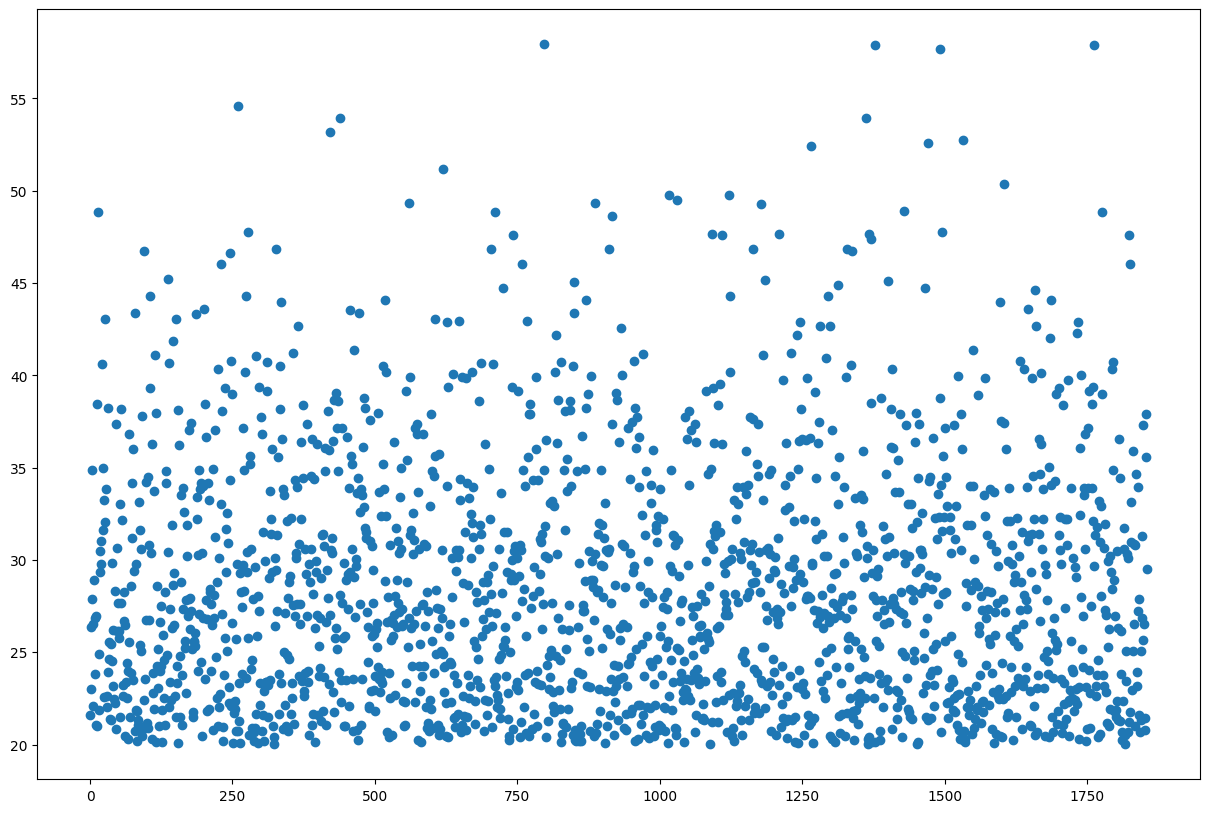

In [20]:
num_high_snr_traces = int(full_SNR_of_high_SNR_traces.shape[0])
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(range(num_high_snr_traces), full_SNR_of_high_SNR_traces);